In [21]:
from validator.InstanceCO22 import InstanceCO22
import warnings
from collections import OrderedDict
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
from util import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from vrpy import VehicleRoutingProblem
import pprint
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.CRITICAL)
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
instance = loadInstance(26)

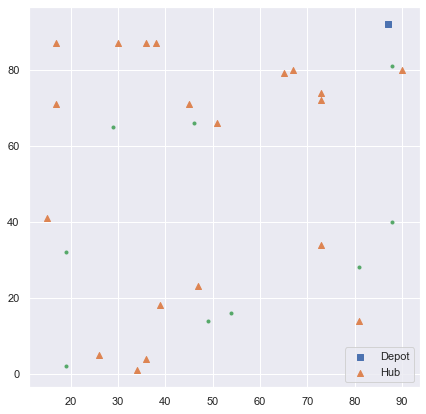

In [4]:
plotInstance(instance)

In [5]:
def locIDtoHubID(loc_ID):
    return loc_ID - 1

def hubIDtoLocID(hub_ID):
    return hub_ID + 1

In [6]:
def distance(loc1: InstanceCO22.Location, loc2: InstanceCO22.Location, ceil: bool = True) -> float:
    dist =  math.sqrt((loc1.X - loc2.X)**2 + (loc1.Y - loc2.Y)**2)
    if ceil:
        return math.ceil(dist)
    else:
        return dist

In [7]:
def requestClosestHub(instance: InstanceCO22, request: InstanceCO22.Request) -> int:
    nHubs = len(instance.Hubs)
    hubs = instance.Locations[1:nHubs+1]
    minDist = math.inf
    minDistHubLocID = None
    for i, hub in enumerate(hubs):
        if request.ID in instance.Hubs[i].allowedRequests:
            hubDist = distance(instance.Locations[request.customerLocID-1],hub)
            if hubDist < minDist:
                minDist = hubDist
                minDistHubLocID = hub.ID
    return minDistHubLocID

In [8]:
def requestsClosestHub(instance: InstanceCO22) -> dict:
    #return dictionary of {'LOC_ID': ' NEAREST LOC_ID'}
    res = {}
    for req in instance.Requests:
        res[req.ID] = requestClosestHub(instance, req)
    return res

In [9]:
def requestsPerHub(instance: InstanceCO22) -> dict:
    closestHubPerRequest = requestsClosestHub(instance= instance)
    nHubs = len(instance.Hubs)
    hubLocIDs = list(range(2,nHubs+2))
    res = {val: [] for val in hubLocIDs}
    for hubLocID in hubLocIDs:
        for reqID, closestHubLocID in closestHubPerRequest.items():
            if closestHubLocID is hubLocID:
                res[hubLocID].append(reqID)
    return res

In [10]:
def amountPerProduct(instance: InstanceCO22, requests: list) -> list:
    nProducts = len(instance.Products)
    res = [None]*nProducts
    for i in range(nProducts):
        res[i] = sum([req.amounts[i] for req in requests])
    return res

In [11]:
def filterRequests(instance: InstanceCO22, day: int = None, locationsID: int = None) -> list:
    res = instance.Requests.copy()
    if day != None:
        res = [_ for _ in res if _.desiredDay is day]
    if locationsID != None:
        res = [_ for _ in res if _.customerLocID in locationsID]
    return res

In [12]:
def addAllEdges(G: nx.DiGraph) -> nx.DiGraph:
    for locID1, node1 in G.nodes(data=True):
        for locID2, node2 in G.nodes(data=True):
            if locID1 != locID2:
                dist = math.ceil( math.sqrt( pow(node1['X']-node2['X'],2) + pow(node1['Y']-node2['Y'],2) ))
                if locID1 == "Sink" or locID2 == "Source" or (locID1 == "Source" and locID2 == "Sink"):
                    continue
                else:
                    G.add_edge(locID1, locID2, time = dist, cost=dist)   
    return G        

In [13]:
def createNxHub(instance: InstanceCO22, hubLocID: int, requests: list) -> nx.DiGraph:
    G = nx.DiGraph()
    for req in requests:
        reqLoc = instance.Locations[req.customerLocID-1]
        G.add_node(req.ID, locID = reqLoc.ID, reqID = req.ID, X=reqLoc.X, Y=reqLoc.Y, demand = sum(req.amounts), amounts = req.amounts)
    hubLoc = instance.Locations[hubLocID]
    G.add_node("Source", locID = hubLocID, X=hubLoc.X, Y=hubLoc.Y)
    G.add_node("Sink",locID = hubLocID, X=hubLoc.X, Y=hubLoc.Y)
    G = addAllEdges(G)
    return G

In [14]:
def solveHubVRP(instance: InstanceCO22, hubLocID: int, requests: list) -> dict:
    #create networkX
    G = createNxHub(instance, hubLocID, requests)
    G_dict = {i:v for i,v in G.nodes(data=True)}
    #print(G_dict.keys())
    prob = VehicleRoutingProblem(G, load_capacity=instance.VanCapacity)
    prob.duration = instance.VanMaxDistance
    prob.fixed_cost = instance.VanDayCost
    prob.solve()
    best_routes = prob.best_routes
    #best_routes = {id:listReplace(best_routes[id], ["Source","Sink"], hubLocID) for id in best_routes.keys()}
    res =  {
        'routes': {key: {'route': [G_dict[id] for id in best_routes[key]]} for key in best_routes.keys()},
        'demand': sum([sum(req.amounts) for req in requests]),
        'amounts': amountPerProduct(instance, requests)
    }
    return res

In [15]:
def createNxDepot(instance: InstanceCO22, dayRoutes: dict) -> nx.DiGraph:
    G = nx.DiGraph()
    #add hubs
    for hubLocID, hubData in dayRoutes.items():
        G.add_node(hubLocID, locID = hubLocID, demand = hubData['demand'], amounts= hubData['amounts'], X=instance.Locations[hubLocID].X, Y=instance.Locations[hubLocID].Y)

    G.add_node("Source", locID=1, X = instance.Locations[0].X, Y = instance.Locations[0].Y)
    G.add_node("Sink", locID=1, X = instance.Locations[0].X, Y = instance.Locations[0].Y)

    G = addAllEdges(G)
    return G

In [16]:
def solveDepotVRP(instance: InstanceCO22, dayRoutes: dict) -> dict:
    #for solving per day
    G = createNxDepot(instance, dayRoutes)
    G_dict = {i:v for i,v in G.nodes(data=True)}
    print(G_dict.keys())

    prob = VehicleRoutingProblem(G, load_capacity=instance.TruckCapacity)
    prob.duration = instance.TruckMaxDistance
    prob.fixed_cost = instance.TruckDayCost
    prob.solve()
    best_routes = prob.best_routes
    #best_routes = {id:listReplace(best_routes[id], ["Source","Sink"], hubLocID) for id in best_routes.keys()}
    res =  {key: [G_dict[id] for id in best_routes[key]] for key in best_routes.keys()}
    return res

In [17]:
def solveHub(instance: InstanceCO22) -> dict:
    nDays = instance.Days
    nHubs = len(instance.Hubs)
    hubLocIDs = list(range(2,nHubs+2))
    hubClusters = requestsPerHub(instance)
    hubRoutes = {}  
    for day in range(1, nDays+1):                                                   #hub routing
        dayRoutes = {}
        for hubLocID in hubLocIDs:
            hubCluster = hubClusters[hubLocID]
            #requestsToServe = filterRequests(instance, day, hubCluster)
            requestsToServe =[_ for _ in instance.Requests if _.ID in hubCluster and _.desiredDay is day]
            print(hubCluster, [_.ID for _ in requestsToServe])   #
            if(len(requestsToServe) > 0):
                dayHubRoutes = solveHubVRP(instance, hubLocID, requestsToServe)
                dayRoutes[hubLocID] = dayHubRoutes
        hubRoutes[day] = dayRoutes
    return hubRoutes

In [23]:
%%capture
res = solveHub(instance)

INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 472 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 472 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 472.0
INFO:vrpy.master_solve_pulp:total cost = 472.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 422 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 422 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 422.0
INFO:vrpy.master_solve_pulp:total cost = 422.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 444 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 444 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 444.0
INFO:vrpy.master_solve_pulp:total cost = 444.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 508 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 508 and 1 vehic

In [34]:
def giantDepotNx(hubRoute: dict) -> nx.DiGraph:
    G = nx.DiGraph()
    DAY_LENGTH = 1000
    daysFresh = [_.daysFresh for _ in instance.Products]
    productIDs = list(range(1, len(instance.Products)+1))
    for day, dayRoute in hubRoute.items():  # for every day
        for hubLocID, hubData in dayRoute.items():  # for every hub
            for productID in productIDs:
                productDemand = hubData['amounts'][productID-1]
                if productDemand > 0:
                    upper = day * DAY_LENGTH
                    lower = math.max( (day - daysFresh[productID-1]) * DAY_LENGTH, 0 )
                    nodeID = f"d{day}h{hubLocID}p{productID}"
                    G.add_node(
                        nodeID,
                        X=instance.Locations[hubLocID].X,
                        Y=instance.Locations[hubLocID].Y,
                        upper=upper,
                        lower=lower,
                        day=day,
                        productID=productID,
                        hubLocID=hubLocID,
                        demand=productDemand)

    G.add_node("Source", X=instance.Locations[0].X, Y=instance.Locations[0].Y)
    G.add_node("Sink", X=instance.Locations[0].X, Y=instance.Locations[0].Y)
    G = addAllEdges(G)
    return G

In [35]:
%%capture
res = solveHub(instance)

INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 472 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 472 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 472.0
INFO:vrpy.master_solve_pulp:total cost = 472.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 422 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 422 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 422.0
INFO:vrpy.master_solve_pulp:total cost = 422.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 444 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 444 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 444.0
INFO:vrpy.master_solve_pulp:total cost = 444.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 508 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 508 and 1 vehic

In [36]:
G = giantDepotNx(res)

In [40]:
G.nodes(data=True)

NodeDataView({'d1h8p2': {'X': 73, 'Y': 72, 'upper': 1000, 'lower': -6000, 'day': 1, 'productID': 2, 'hubLocID': 8, 'demand': 4}, 'd1h8p3': {'X': 73, 'Y': 72, 'upper': 1000, 'lower': -9000, 'day': 1, 'productID': 3, 'hubLocID': 8, 'demand': 3}, 'd1h13p1': {'X': 39, 'Y': 18, 'upper': 1000, 'lower': -3000, 'day': 1, 'productID': 1, 'hubLocID': 13, 'demand': 8}, 'd1h13p2': {'X': 39, 'Y': 18, 'upper': 1000, 'lower': -6000, 'day': 1, 'productID': 2, 'hubLocID': 13, 'demand': 5}, 'd1h16p1': {'X': 67, 'Y': 80, 'upper': 1000, 'lower': -3000, 'day': 1, 'productID': 1, 'hubLocID': 16, 'demand': 7}, 'd1h16p2': {'X': 67, 'Y': 80, 'upper': 1000, 'lower': -6000, 'day': 1, 'productID': 2, 'hubLocID': 16, 'demand': 9}, 'd1h17p2': {'X': 45, 'Y': 71, 'upper': 1000, 'lower': -6000, 'day': 1, 'productID': 2, 'hubLocID': 17, 'demand': 7}, 'd1h17p3': {'X': 45, 'Y': 71, 'upper': 1000, 'lower': -9000, 'day': 1, 'productID': 3, 'hubLocID': 17, 'demand': 5}, 'd1h21p1': {'X': 19, 'Y': 32, 'upper': 1000, 'lower': 

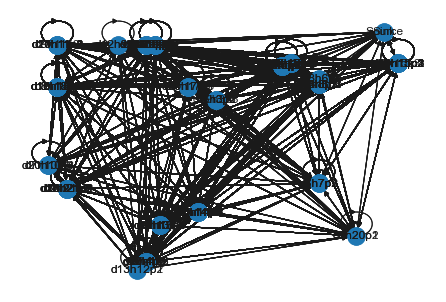

In [39]:
pos = {id: (val['X'],val['Y']) for id,val in G.nodes(data=True)}
nx.draw(G, with_labels=True, pos = pos)

In [63]:
def solve(instance: InstanceCO22) -> dict:
    nDays = instance.Days
    nHubs = len(instance.Hubs)
    hubLocIDs = list(range(2,nHubs+2))
    hubClusters = requestsPerHub(instance)
    hubRoutes = {}  
    for day in range(1, nDays+1):                                                   #hub routing
        dayRoutes = {}
        for hubLocID in hubLocIDs:
            hubCluster = hubClusters[hubLocID]
            #requestsToServe = filterRequests(instance, day, hubCluster)
            requestsToServe =[_ for _ in instance.Requests if _.ID in hubCluster and _.desiredDay is day]
            print(hubCluster, [_.ID for _ in requestsToServe])   #
            if(len(requestsToServe) > 0):
                dayHubRoutes = solveHubVRP(instance, hubLocID, requestsToServe)
                dayRoutes[hubLocID] = dayHubRoutes
        hubRoutes[day] = dayRoutes
    depotRoutes = {}
    for day in range(1, nDays+1):  
        if len(hubRoutes[day])>0:                                                #depot routing
            res = solveDepotVRP(instance, hubRoutes[day])
            depotRoutes[day] = res
        else:
            depotRoutes[day] = {}
    return {'hubRoutes': hubRoutes, 'depotRoutes': depotRoutes}

In [64]:
%%capture
res = solve(instance)

INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 472 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 472 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 472.0
INFO:vrpy.master_solve_pulp:total cost = 472.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 422 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 422 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 422.0
INFO:vrpy.master_solve_pulp:total cost = 422.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 444 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 444 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 444.0
INFO:vrpy.master_solve_pulp:total cost = 444.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 508 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 508 and 1 vehic

In [65]:
print(pprint.pformat(res))

{'depotRoutes': {1: {1: [{'X': 87,
                          'Y': 92,
                          'collect': 0,
                          'demand': 0,
                          'frequency': 1,
                          'locID': 1,
                          'lower': 0,
                          'service_time': 0,
                          'upper': 0},
                         {'X': 73,
                          'Y': 72,
                          'amounts': [0, 4, 3],
                          'collect': 0,
                          'demand': 7,
                          'frequency': 1,
                          'locID': 8,
                          'lower': 0,
                          'service_time': 0,
                          'upper': 0},
                         {'X': 39,
                          'Y': 18,
                          'amounts': [8, 5, 0],
                          'collect': 0,
                          'demand': 13,
                          'frequency': 1,
          

In [66]:
def solutionToStr(instance: InstanceCO22, res: dict):
    resultString = "DATASET = CO2022_11 \n \n"

    for day in range(1, instance.Days+1):
        resultString += f"DAY = {day} \n"
        nTrucks = len(res['depotRoutes'][day])
        resultString += f"NUMBER_OF_TRUCKS = {nTrucks} \n"

        truckString = ""
        for routeID, truckRoute in res['depotRoutes'][day].items():
            truckString += f"{routeID} "
            for i, hubData in enumerate(truckRoute[1:-1]):
                amountPerProduct = hubData['amounts']
                truckString += f"H{hubData['locID'] - 1} {','.join([str(_) for _ in amountPerProduct])} "
            truckString += "\n"
        resultString += truckString

        nVans = 0
        i = 0
        vanString = ""
        for hubLocID in res['hubRoutes'][day].keys():
            for _, route in res['hubRoutes'][day][hubLocID]['routes'].items():
                i+=1
                reqIds = [_['reqID'] for _ in route['route'][1:-1] ]
                vanString += f"{i} H{hubLocID-1} {' '.join([str(_) for _ in reqIds])} \n"
            nVans += len(res['hubRoutes'][day][hubLocID]['routes'])
        resultString += f"NUMBER_OF_VANS = {nVans} \n"  
        resultString += vanString + "\n"
    return resultString
    

In [67]:
solutionStr = solutionToStr(instance,res)
with open("./solution_test_alg1.txt" ,'w') as file:
    file.write(solutionStr)


In [ ]:
#assign hub to locations
#for each day, for each hub:
    #get request for hub, day
    #turn into networkX graph
    #solve using vrpy
    #store results
